# Introduction
In this part of the course, we will discuss about inferential replicates. We will cover the details about the motivation for generating inferential replicates of an experiment, how to generate the inferential replicates using alevin and post process them using various R packages.

## Understanding Inferential Replicates

Exercise Courtesy of Mike Love.
Let's start by first understand some basics of bootstrapping.

Slides: https://github.com/fmicompbio/adv_scrnaseq_2020/blob/master/scrna-seq-quantification/exercise.pdf

We have quantified the 10x [pbmc_1k](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v2) dataset with alevin, and also generated 20 bootstrap inferential replicates. We used the following command to generate the output

```
salmon alevin -lISR -1 R1.fq -2 R2.fq --chromium -i index -p 2 -o output --tgMap tgMap.txt
--numCellBootstraps 20
```

**NOTE**: A new command-line flag `--numCellBootstraps 20`.

Let's check if we can access the output files.

In [1]:
dir <- "pbmc_1k"
files <- file.path(dir, "alevin", "quants_mat.gz")
file.exists(files)

[1] TRUE

In [2]:
system("ls pbmc_1k/alevin", intern=TRUE)

[1] "alevin.log"           "featureDump.txt"      "quants_boot_rows.txt"
 [4] "quants_mat_cols.txt"  "quants_mat.gz"        "quants_mat_rows.txt" 
 [7] "quants_mean_mat.gz"   "quants_tier_mat.gz"   "quants_var_mat.gz"   
[10] "whitelist.txt"

We have seen the following files before:
* `alevin.log`: This file contains the logs generated by alevin while quantifiying the dscRNA-seq data. This is very useful for debugging.
* `featureDump.txt`: This is a tsv file with per-cell level summary stats. This is used for whitelisting of the cells.
* `quants_mat_cols.txt`: alevin output matrix is cell by gene. This file contains the ordered list of genes denoting the column index in the matrix.
* `quants_mat_rows.txt`: alevin output matrix is cell by gene. This file contains the ordered list of cellular barcodes denoting the row index in the matrix.
* `quants_mat.gz`: This file contains the output cell-by-gene count matrix in a binary (non human readable) format. We store it in a compressed EDS format which can be efficiently stored and loaded back into memory. We show some some of the benchmark comparing common single-cell format below.

In this alevin run we have bunch of new files:
* `quants_mean_mat.gz`: The files contains the `mean` of the bootstrap estimates and the values are stored in the EDS format just like `quants_mat.gz`.
* `quants_var_mat.gz`: The files contains the `variance` of the bootstrap estimates and the values are stored in the EDS format just like `quants_mat.gz`.
* `whitelist.txt`: Alevin performs an inteliigent whitelisting procedure using features from the `featureDump.txt` file to classify the quantified barcodes 
into high or low confidence barcodes.

## Importing alevin data with tximeta

We will use [tximeta](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007664) to import the [alevin](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1670-y) counts into
R. The main function `tximeta` reads information from the
entire output directory of alevin in order to
automatically detect and download metadata about the reference
sequences (the transcripts). It should work "out of the
box" for human, mouse, and fruit fly reference transcripts from
GENCODE, Ensembl, or RefSeq.

**Note:** For typical use, you would just specify the path to the directory 
of the output from alevin.

**Note:** when sharing alevin datasets, make sure
to share the entire output directory (you can `zip` or `tar` the
directories to make them into a single share-able file).

We can import the alevin quantification using the following call to
`tximeta`. The extra argument to alevin will filter out cells based
on alevin's post-quantification quality control methods (see paper
for details).

In [3]:
suppressPackageStartupMessages(library(BiocGenerics))
suppressPackageStartupMessages(library(S4Vectors))
library(tximeta)

In [4]:
se <- tximeta(files, type="alevin", alevinArgs=list(filterBarcodes=TRUE))

importing quantifications

reading in alevin gene-level counts across cells with fishpond

filtering down to 1142 cell barcodes

reading in alevin inferential variance with fishpond

found matching transcriptome:
[ GENCODE - Homo sapiens - release 33 ]

building TxDb with 'GenomicFeatures' package

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
"The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored."
OK

generating gene ranges

generating gene ranges

fetching genome info for GENCODE



We can see as it was importing that it automatically detected we are
working with data quantified using GENCODE's *Homo sapiens* reference
transcripts, release 33. The transcript metadata was added
programmatically to the output (this object, `se`). `tximeta` is also
written in such a way that it will avoid unnecessary downloads and
parsing of files -- it will first attempt to find a cached version of
the metadata, to avoid re-downloading or re-parsing these files.

`tximeta` returns a [SummarizedExperiment](https://bioconductor.org/packages/release/bioc/html/SummarizedExperiment.html). We can
easily convert this object into a [SingleCellExperiment](http://bioconductor.org/packages/release/bioc/html/SingleCellExperiment.html)
which has specific slots designed for single-cell
experiment data.

In [5]:
system("cat pbmc_1k/aux_info/meta_info.json", intern=TRUE)

[1] "{"                                                                                                                                                                
 [2] "    \"salmon_version\": \"1.3.0\","                                                                                                                               
 [3] "    \"samp_type\": \"none\","                                                                                                                                     
 [4] "    \"opt_type\": \"em\","                                                                                                                                        
 [5] "    \"quant_errors\": [],"                                                                                                                                        
 [6] "    \"num_libraries\": 1,"                                                                                                                                        
 [7] "    \"library_types\": ["                                                                                                                                         
 [8] "        \"ISR\""                                                                                                                                                  
 [9] "    ],"                                                                                                                                                           
[10] "    \"frag_dist_length\": 1001,"                                                                                                                                  
[11] "    \"seq_bias_correct\": false,"                                                                                                                                 
[12] "    \"gc_bias_correct\": false,"                                                                                                                                  
[13] "    \"num_bias_bins\": 4096,"                                                                                                                                     
[14] "    \"mapping_type\": \"mapping\","                                                                                                                               
[15] "    \"keep_duplicates\": false,"                                                                                                                                  
[16] "    \"num_valid_targets\": 227063,"                                                                                                                               
[17] "    \"num_decoy_targets\": 0,"                                                                                                                                    
[18] "    \"num_eq_classes\": 0,"                                                                                                                                       
[19] "    \"serialized_eq_classes\": false,"                                                                                                                            
[20] "    \"eq_class_properties\": ["                                                                                                                                   
[21] "        \"gzipped\""                                                                                                                                              
[22] "    ],"                                                                                                                                                           
[23] "    \"length_classes\": ["                                                                                                                                        
[24] "        539,"                                                                                               

In [6]:
suppressPackageStartupMessages(library(SingleCellExperiment))
sce <- as(se, "SingleCellExperiment")

The SingleCellExperiment object is used widely across Bioconductor packages (as you may already know), and so the code up to this point can be used as an entry point into other R/Bioconductor single cell workflows.

## Add cell annotations

To visualize the inferential replicates, let's first cluster and extract the expected cell-types for the cellular barcodes. We use [Seurat](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867419305598%3Fshowall%3Dtrue) to cluster and use find marker genes [vignette](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html) to assign cell-types.
We start by first extracting the count matrix from the _SingleCellExperiment_ object and generate the Seurat object from that.

In [9]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))

# create seurat object for whitelisted cells
cts <- assays(sce)[["counts"]]
pbmc <- CreateSeuratObject(cts)
pbmc

An object of class Seurat 
60233 features across 1142 samples within 1 assay 
Active assay: RNA (60233 features, 0 variable features)

We perform some basic filtering to remove noisy cells.

An object of class Seurat 
60233 features across 1068 samples within 1 assay 
Active assay: RNA (60233 features, 0 variable features)

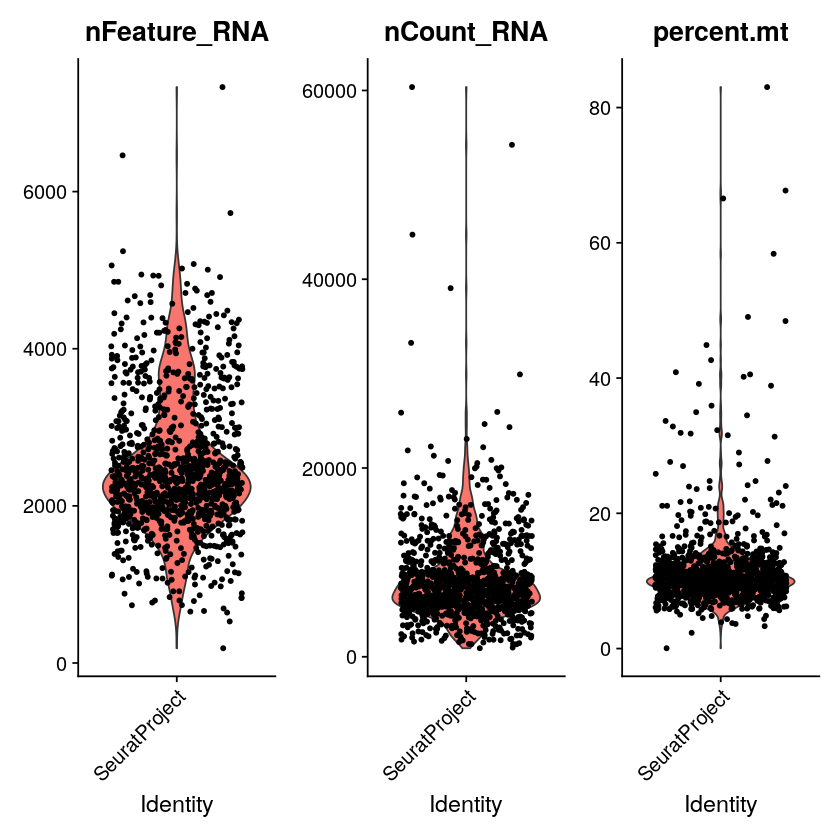

In [10]:
mt.genes <- rownames(sce)[as.logical(seqnames(sce) == "chrM")]
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, features = mt.genes)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

# filtering some outlier cells
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 20 & nCount_RNA < 20000)
pbmc

We normalize the data, extract PCA embeddings, run clustering algorithm & generate UMAP embeddings.

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


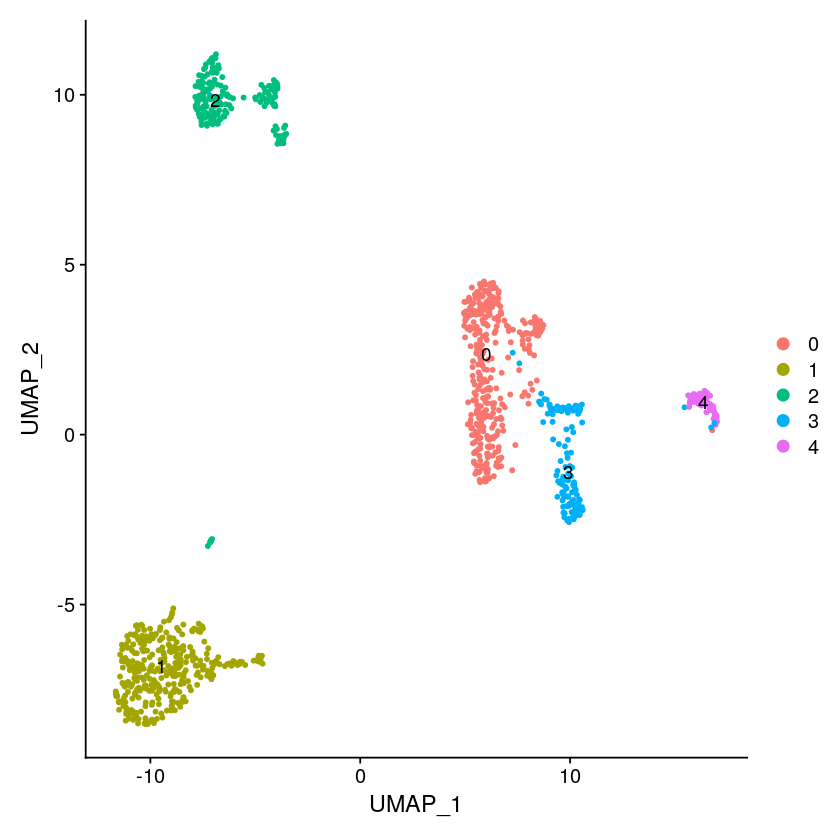

In [11]:
# Normalize and runPCA
pbmc <- FindVariableFeatures(pbmc) %>%  NormalizeData() %>%  ScaleData(verbose = F) %>% RunPCA(verbose = F)

# Cluster the cells
pbmc <- FindNeighbors(pbmc, dims = 1:25, verbose = F)
pbmc <- FindClusters(pbmc, resolution = 0.15, verbose = F)

# plotting umap embeddings
pbmc <- RunUMAP(pbmc, dims = 1:25, verbose = F)
DimPlot(pbmc, label = T)

We find the marker genes using the standard Seurat workflow

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4



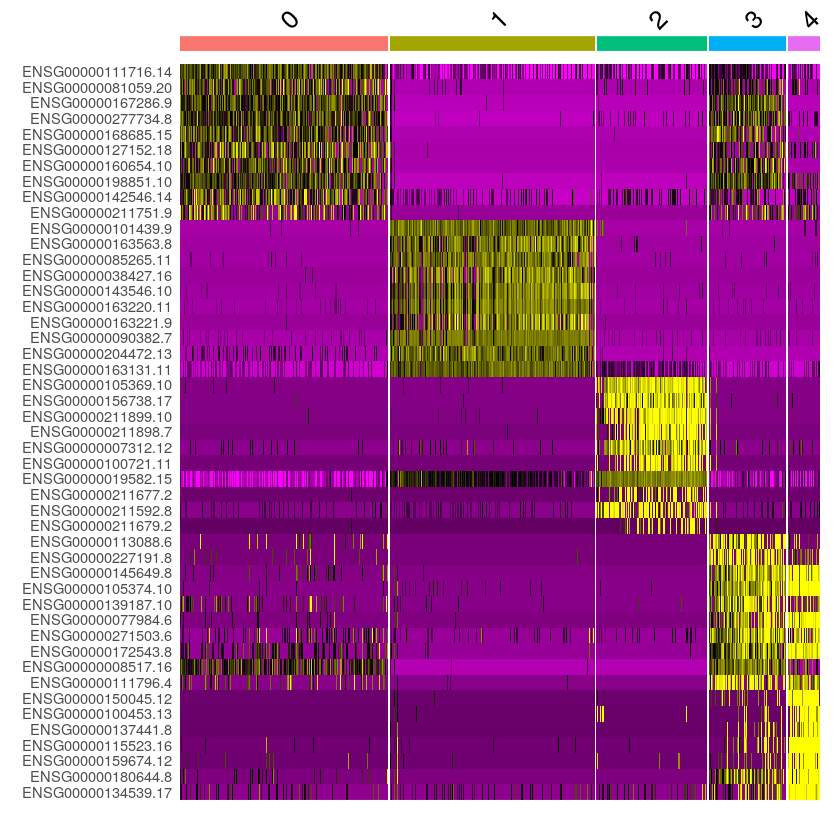

In [12]:
# Find marker genes & extract top 10 genes
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

Using the marker genes we assign each cluster their expected cell-types.

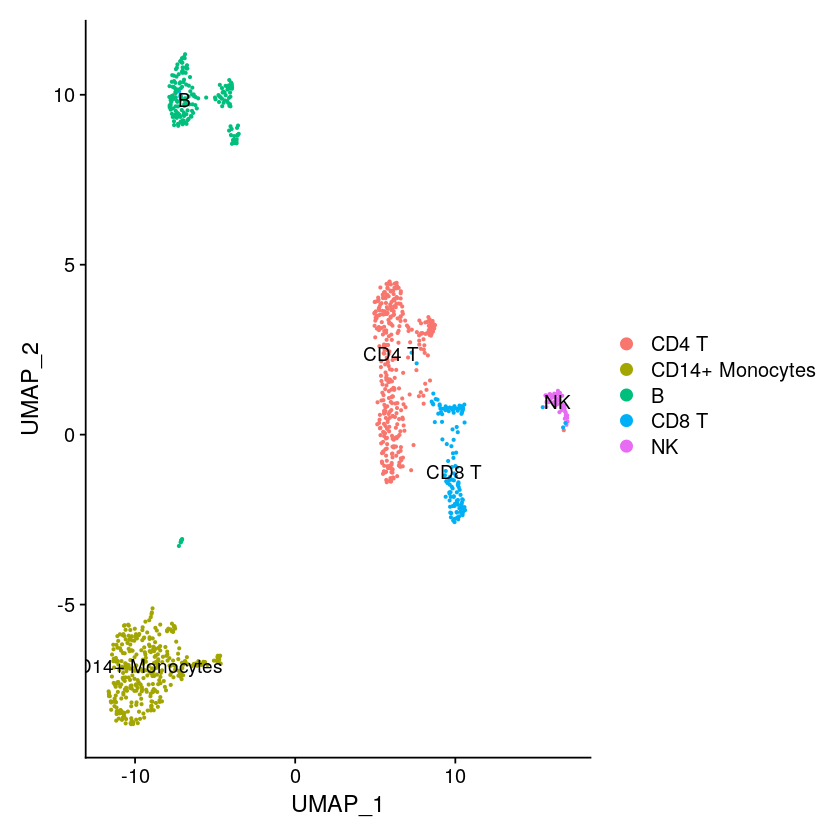

In [13]:
# Assigning Cluster names based on marker genes
# "CD14+ Monocytes" "CST3" "ENSG00000101439.9"
# "CD4 T" "IL7R" "ENSG00000168685.15"
# "B" "MS4A1" "ENSG00000156738.17"
# "CD8 T" "KLRB1" "ENSG00000111796.4" (we use only for this particular set of cells)
# "NK" "GNLY" "ENSG00000115523.16"

markers.vec <- c("CD14+ Monocytes"="ENSG00000101439.9", "CD4 T"="ENSG00000168685.15", "B"="ENSG00000156738.17", "CD8 T"="ENSG00000111796.4", "NK"="ENSG00000115523.16")
clusters <- character(5)
for (i in seq_along(markers.vec)) {
  idx <- which(top10$gene == markers.vec[i])
  stopifnot(length(idx) == 1)
  cluster.idx <- as.numeric(as.character(top10$cluster[idx])) + 1
  clusters[cluster.idx] <- names(markers.vec)[i]
}

top10$cluster.name <- rep(clusters, each=10)
df <- as.data.frame(top10)
# write.csv(df, file="../extdata/top10.csv")

names(clusters) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, clusters)
# saveRDS(Idents(pbmc), file="../extdata/idents.rds")

DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) 

Since not all cell had been We subset to the cells that we have IDs for, and attach the labels in
the correct order:

In [14]:
ids <- Idents(pbmc)

idx <- colnames(sce) %in% names(ids)
table(idx)
sce <- sce[,idx]
sce$cluster <- ids[colnames(sce)]

idx
FALSE  TRUE 
   74  1068 

The number of cells per cluster:

In [15]:
table(sce$cluster)


          CD4 T CD14+ Monocytes               B           CD8 T              NK 
            351             346             187             130              54 

## Plotting counts with uncertainty

In this section, we will begin to plot the counts for cells, for
specific genes, and showing the inferential uncertainty as
quantified by alevin. This is a unique aspect to the alevin
quantification method, that it retains gene multi-mapping reads,
instead of discarding these reads. alevin can also attach a measure
of uncertainty to each count in the matrix. alevin computes the mean
and variance of inferential replicates which are generated by
bootstrapping the read data. `tximeta` will import these inferential
mean and variance matrices by default (they are also sparse, similar
to the counts matrix).

We will first visualize the uncertainty, and later give an
example of a set of genes where the uncertainty is indicating
significant quantification uncertainty which is useful to consider
when performing EDA (exploratory data analysis) or statistical
analysis.

In [16]:
o <- order(colSums(assays(sce)[["counts"]]), decreasing=TRUE)
sce <- sce[,o]

We can now use a plotting function `plotInfReps` from the fishpond
package in order to plot the inferential mean and variance for the
cells, for various genes.

In [17]:
source("R/plot.R")


Attaching package: 'fishpond'


The following object is masked _by_ '.GlobalEnv':

    plotInfReps




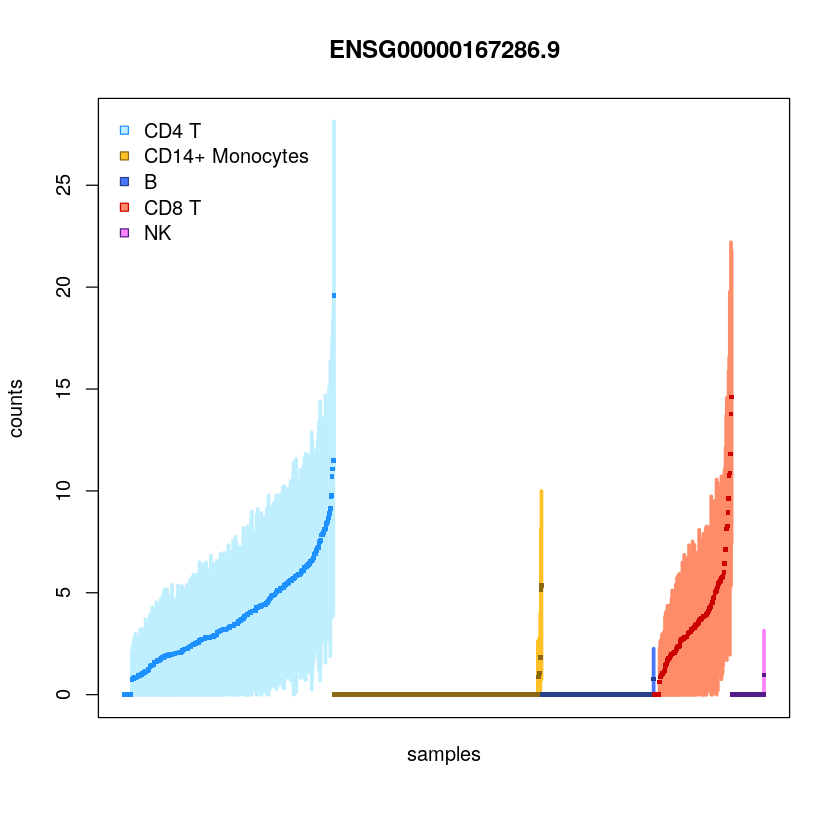

In [18]:
library(fishpond)
plotInfReps(sce, idx="ENSG00000167286.9", x="cluster",
            legend=TRUE, reorder = T)

Here, we have x as a grouping variable for coloring the points, one can also specify x to be a continuous covariate, e.g. pseudo-time. An additional covariate cov can be used for additional grouping, e.g. batches, donors or lineages.

Here we show the same plot but now subsetting the number of cells:

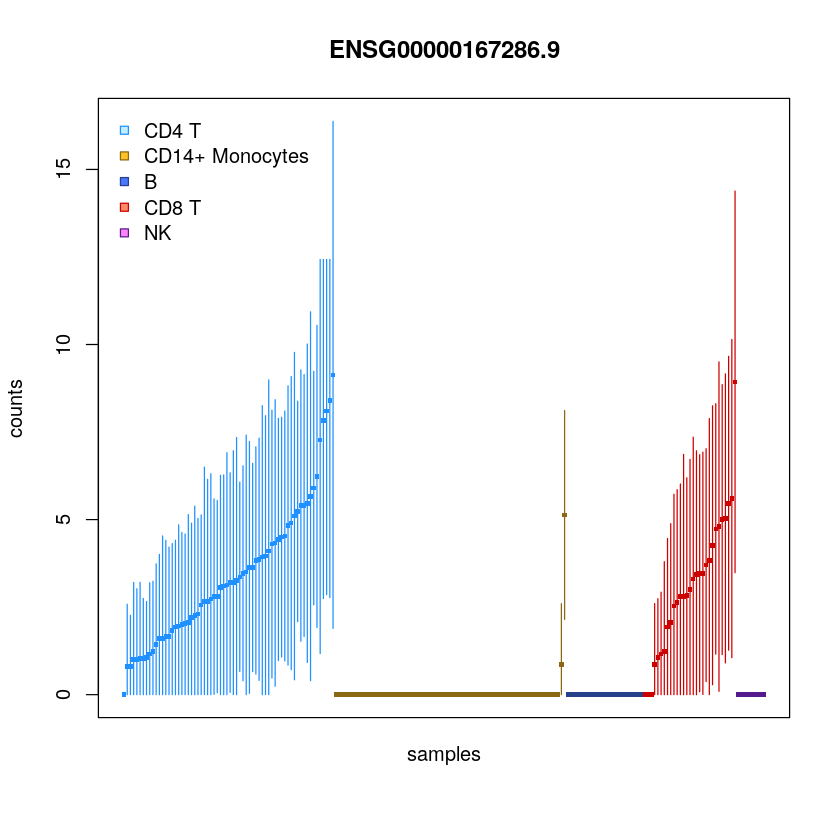

In [19]:
idx <- sample(ncol(sce),200)
plotInfReps(sce[,idx], idx="ENSG00000167286.9",
            x="cluster", legend=TRUE, reorder = T)

This time only 100 cells:

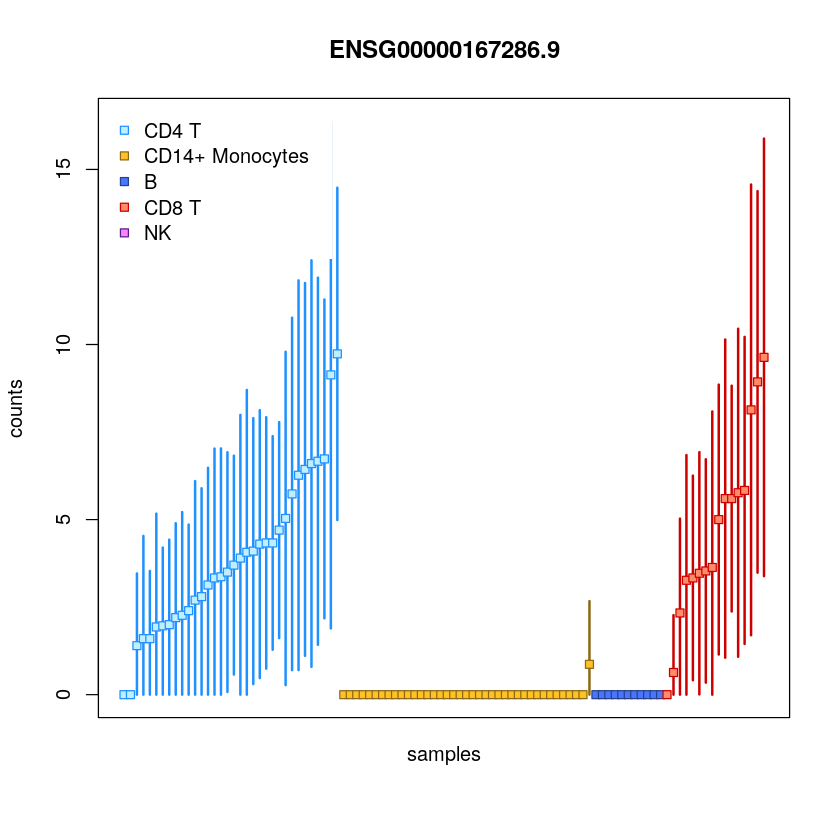

In [20]:
idx <- sample(ncol(sce),100)
plotInfReps(sce[,idx],
            idx="ENSG00000167286.9",
            x="cluster",
            legend=TRUE, reorder = T)

## Inferential variance (uncertainty)

In this section, we will briefly talk about how the
inferential uncertainty as stored in the variance assay may be useful
in practice.

Many users may prefer to just work with the counts matrix, and not
consider the inferential mean and variance. We have found that,
globally, this may not lead to too much of a problem, but for certain
genes, it may be important to use the inferential variance in cases
where it may signal difficult to quantify genes. Inferential
uncertainty for bulk and single cell RNA-seq differential expression
was a focus of the [Swish](https://academic.oup.com/nar/article/47/18/e105/5542870) 
nonparametric statistical method which we do not demonstrate here, but one can refer to
the vignette of [swish](https://bioconductor.org/packages/swish) for
more details (in particular the section on alevin data).

Let's start by visualizing the uncertainty across all values in the
matrix: 

In [21]:
var <- as.vector(assays(sce)[["variance"]])
mu <- as.vector(assays(sce)[["mean"]])
idx <- mu > 3
df <- data.frame(log10mean=log10(mu[idx]),
                 log10var=log10(var[idx]))

In [22]:
head(df)

,log10mean,log10var
,<dbl>,<dbl>
1,1.0660661,1.1321443
2,0.7429868,0.8313720
3,1.6148972,1.7363434
4,0.4819201,0.4912060
5,1.1015180,1.1238154
6,0.5720968,0.3415444


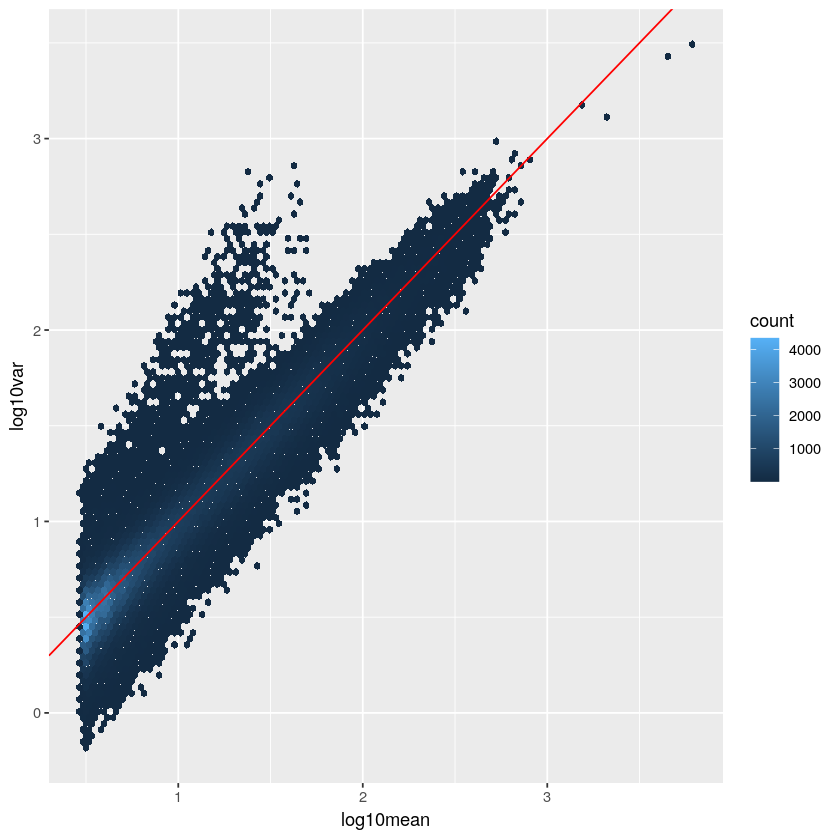

In [23]:
library(ggplot2)
ggplot(df, aes(log10mean, log10var)) +
  geom_hex(bins=100) + 
  geom_abline(intercept=0, slope=1, col="red")

The values around the red line indicate not much uncertainty. However we can see a tail of higher uncertainty values in the matrix, where the inferential variance is for example, up to 10 times higher than the mean.

We can also plot this summarized to a single value per gene, here we calculate the 99% quantile of the ratio of variance over mean, per gene, and plot this over the mean:

In [24]:
library(matrixStats)
rmu <- rowMeans(assays(sce)[["mean"]])
idx <- rmu > .1

rratio <- rowQuantiles(as.matrix(
  assays(sce)[["variance"]] /
  (assays(sce)[["mean"]] + 1)), probs=.99)

df <- data.frame(log10mean=log10(rmu[idx]),
                 rratio=rratio[idx],
                 gene=mcols(sce)$gene_id[idx])

A number of genes have a ratio above 2, but then two genes in this dataset stand out above the rest, and they happen to be a ribosomal gene, and another gene that is a read-through of the same locus:

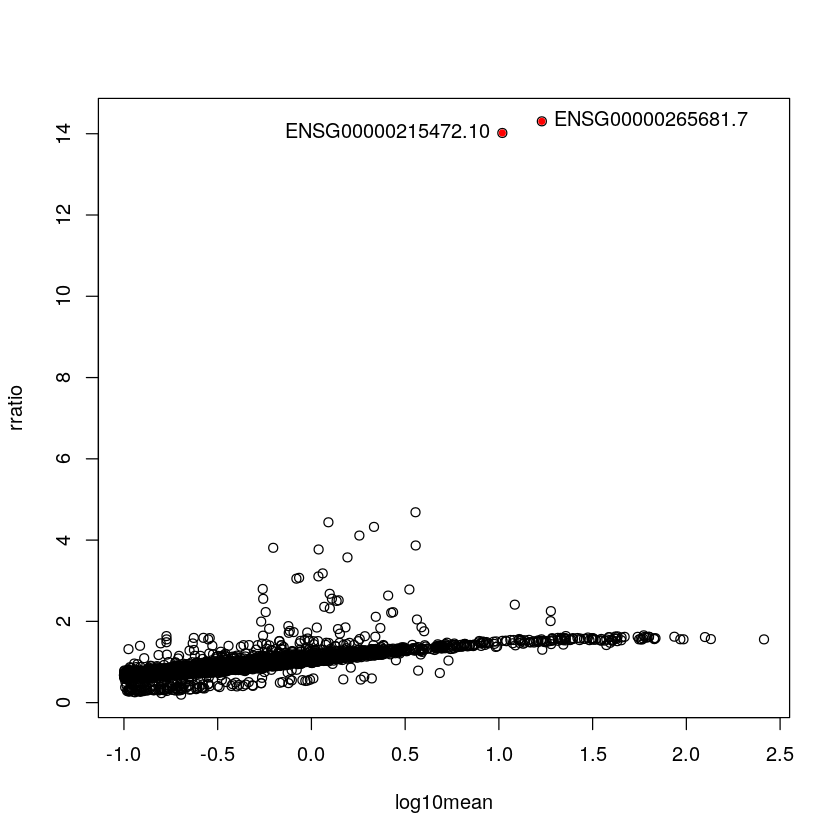

In [25]:
with(df, plot(log10mean, rratio))
high.uncert <- which(df$rratio > 10)
with(df[high.uncert,],
     points(log10mean, rratio, pch=20, col="red"))
with(df[high.uncert,],
     text(log10mean, rratio, gene, pos=c(2,4)))

In [26]:
mcols(sce)$gene_id[idx][high.uncert]

[1] "ENSG00000215472.10" "ENSG00000265681.7"

Some of the counts for the ribosomal gene and its read-through:

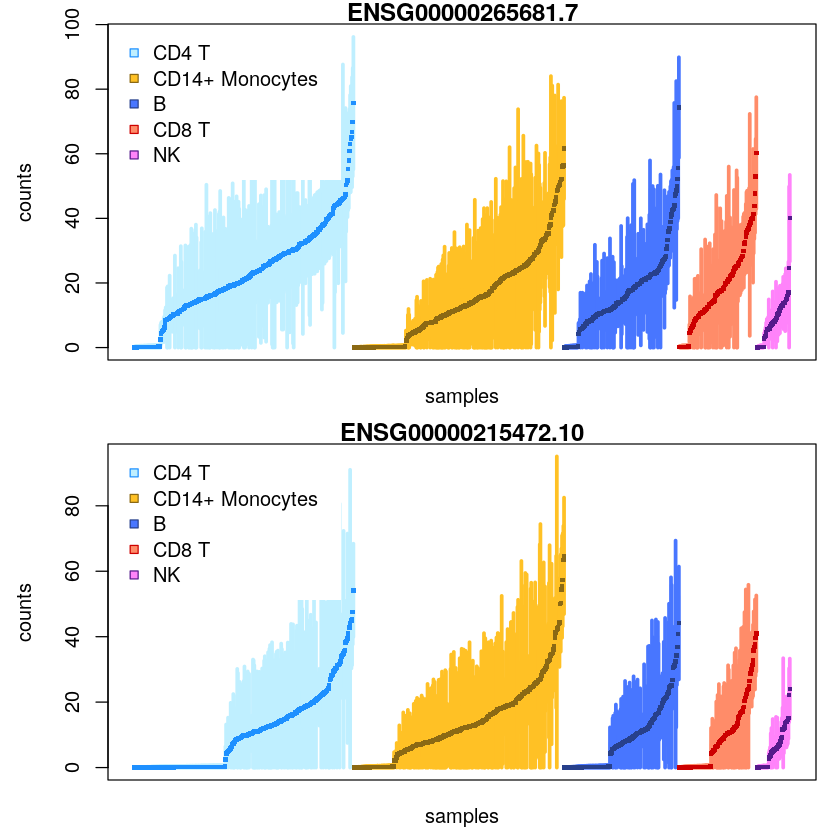

In [27]:
par(mfrow=c(2,1), mar=c(2.5,4.5,1,1))
plotInfReps(sce[,1:1000], idx="ENSG00000265681.7",
            legend=TRUE, x="cluster", reorder=T)
plotInfReps(sce[,1:1000], idx="ENSG00000215472.10",
            legend=TRUE, x="cluster", reorder=T)

The extra uncertainty on the counts for this gene indicate that alevin was not certain if the reads should come from the gene or its read-through. While in this case, the ribosomal gene may not be over interest, there are other cases (e.g. developmental or immune genes with high sequence homology) where information of the uncertainty of quantification can be useful in interpreting the data. For example, the uncertainty among the marker genes is in reasonable bounds.

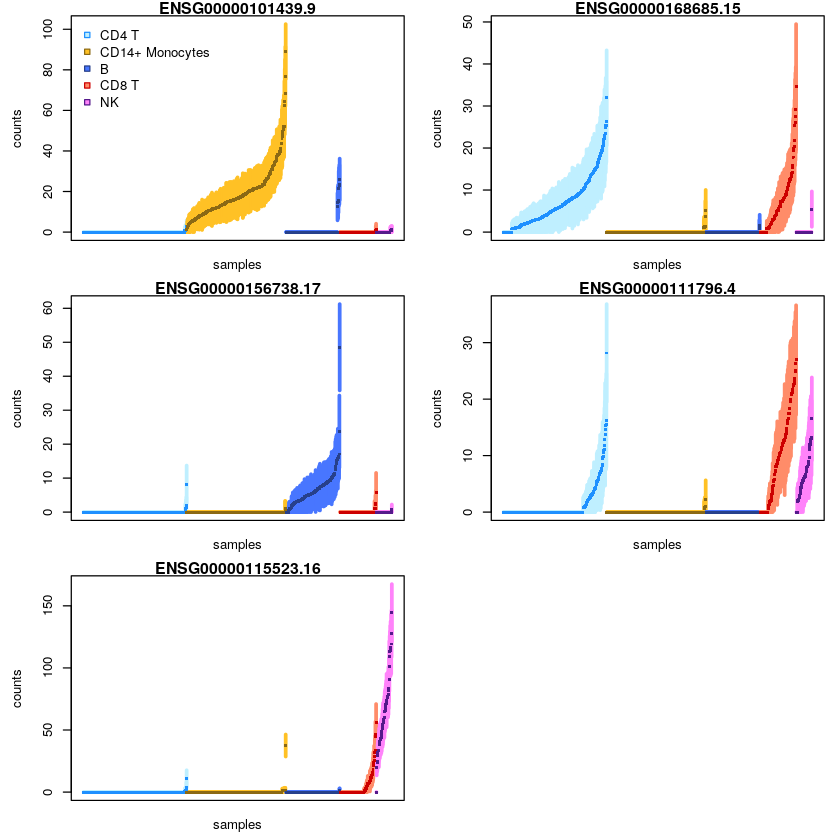

In [28]:
par(mfrow=c(3,2), mar=c(2.5,4.5,1,1))
plotInfReps(sce[,1:1000], idx=markers.vec[1],
            legend=TRUE,x="cluster", reorder=T)
plotInfReps(sce[,1:1000], idx=markers.vec[2],
            x="cluster", reorder=T)
plotInfReps(sce[,1:1000], idx=markers.vec[3],
            x="cluster", reorder=T)
plotInfReps(sce[,1:1000], idx=markers.vec[4],
            x="cluster", reorder=T)
plotInfReps(sce[,1:1000], idx=markers.vec[5],
            x="cluster", reorder=T)

## Summary

In this exercise we learned:
* The methodological process of inferential replicate generation.
* How to generate inferential replicates using alevin and import them into R.
* How to use the inferential replicate in a downstream analysis.